In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
#loading data
df = pd.read_csv("./data-csv-files/dam_occupancy.csv").drop("GENERAL_DAM_RESERVED_WATER", axis=1)
df.columns = ["date", "occupancy_rate"]
df["date"] = pd.to_datetime(df["date"])
df.head()

date  occupancy_rate
0 2005-01-01           44.62
1 2005-01-02           44.62
2 2005-01-03           44.47
3 2005-01-04           44.42
4 2005-01-05           44.35

In [3]:
df.describe().T

count       mean        std  min    25%     50%      75%  \
occupancy_rate  5818.0  65.214392  23.239418  9.2  48.98  67.095  86.4175   

                  max  
occupancy_rate  99.16

## Visualization

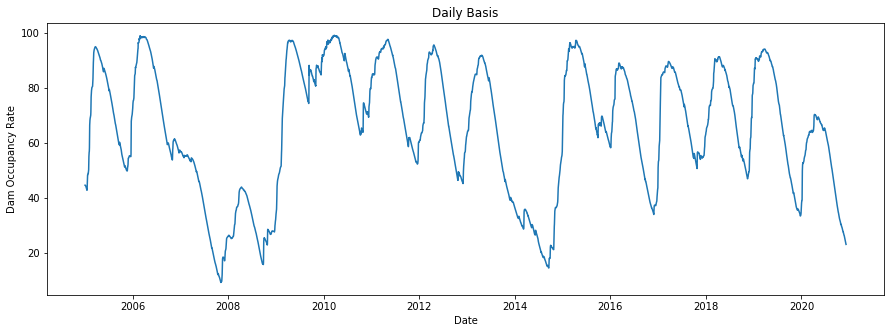

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(df.date, df.occupancy_rate) 
plt.xlabel("Date")
plt.ylabel("Dam Occupancy Rate")
plt.title("Daily Basis")
plt.show()

Data have 5818 samples and it takes so much time to process hence converting data monthly basis saves time.

In [5]:
#converting data to monthly basis 
df = df.resample("M", on="date").mean().reset_index()
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m'))
df.set_index('date', inplace=True)
print("Number of samples after converting: ", df.shape[0])

Number of samples after converting:  192


In [6]:
df.head()

occupancy_rate
date                   
2005-01       46.650000
2005-02       72.679286
2005-03       92.837097
2005-04       92.331667
2005-05       87.719677

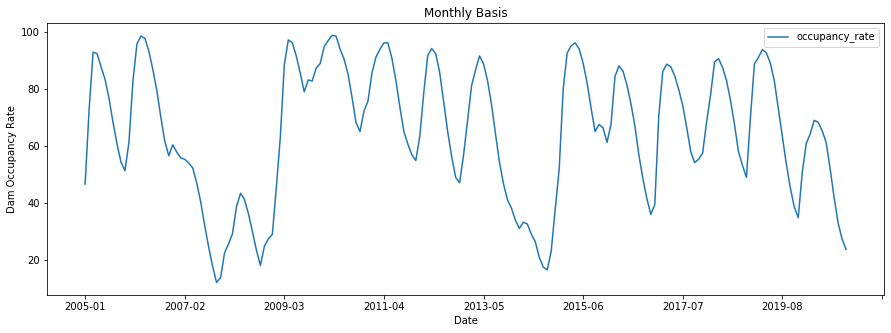

In [7]:
df.plot(figsize=(15, 5))
plt.xlabel("Date")
plt.ylabel("Dam Occupancy Rate")
plt.title("Monthly Basis")
plt.show()

## Stationarity

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The algebraic equivalent is thus a linear function, perhaps, and not a constant one; the value of a linear function changes as 𝒙 grows, but the way it changes remains constant — it has a constant slope; one value that captures that rate of change.

https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322

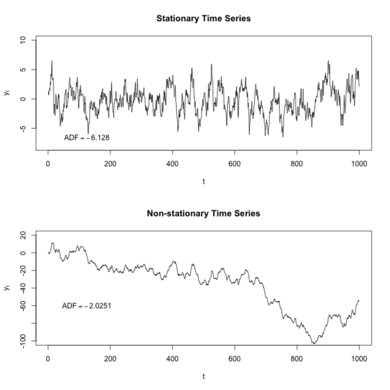

In [8]:
# Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adfuller_test(df['occupancy_rate'])

ADF Test Statistic : -3.832184880607515
p-value : 0.0025946642499831874
#Lags Used : 12
Number of Observations Used : 179
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Autocorrelation and Partial Autocorrelation

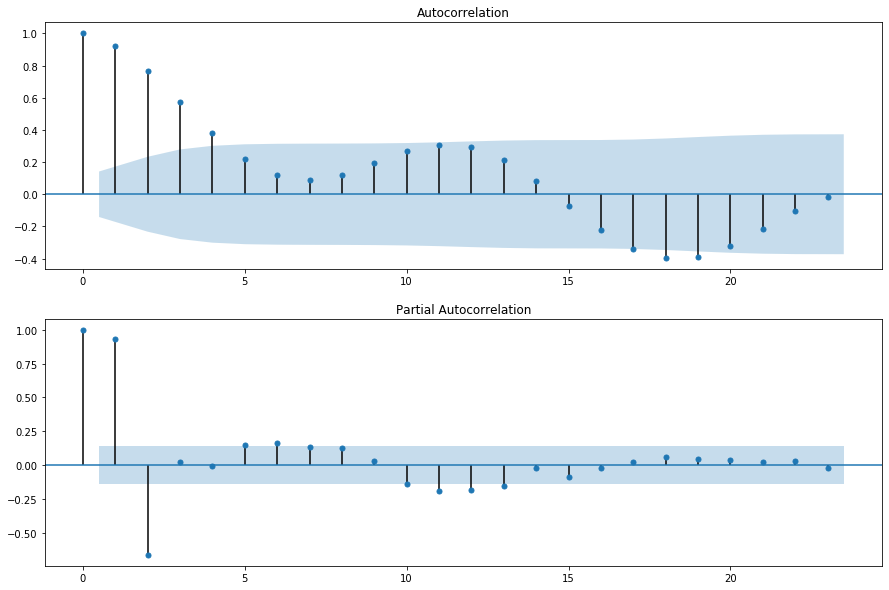

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(211)
plot_acf(df["occupancy_rate"], ax=ax1)

ax2=fig.add_subplot(212)
plot_pacf(df["occupancy_rate"], ax=ax2)

plt.show()

## ARIMA

ARIMA is an acronymthat stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler Autoregressive Moving Average and adds the notion of integration.

- <b>AR:Autoregression:</b>  A model that uses the dependent relationship between an observationand some number of lagged observations.
- <b>I:Integrated:</b>  The use of differencing of raw observations (e.g.  subtracting an observationfrom an observation at the previous time step) in order to make the time series stationary.
- <b>MA:Moving Average:</b>  A model that uses the dependency between an observation and aresidual error from a moving average model applied to lagged observation

Each of these components are explicitly specified in the model as a parameter.  A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.The parameters of the ARIMA model are defined as follows:

- <b>p:</b>  The number of lag observations included in the model, also called the lag order.
- <b>d:</b>  The number of times that the raw observations are differenced, also called the degreeof differencing.
- <b>q:</b>  The size of the moving average window, also called the order of moving average.

To select the model parameters autocorrelation and parital autocorrelation can be used. 
https://people.duke.edu/~rnau/arimrule.htm

In [11]:
#dividing data into train and test
train = df.occupancy_rate[:160]
test = df.occupancy_rate[160:]

In [12]:
#creating possible parameters/parameter space
import itertools
p=d=q=range(0, 5)
pdq_range = list(itertools.product(p, d, q))

In [13]:
from statsmodels.tsa.arima_model import ARIMA

results = {}

for pdq in pdq_range:
    try:
        model = ARIMA(train, order=pdq)
        model_fit = model.fit()
        results[str(pdq)] = model_fit.aic
    except:
        continue    

In [14]:
#selecting parameters that have minimum error
print("Best parameters: ", min(results, key=results.get))

Best parameters:  (2, 1, 4)


In [15]:
#arima model with best parameters and its forecast for the test data
arima = ARIMA(train, order=(2, 1, 4))
arima_fit = arima.fit()

preds = arima_fit.forecast(steps=32)[0]

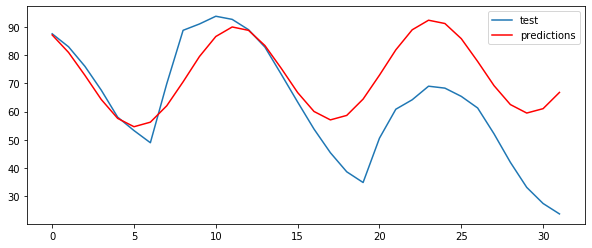

In [16]:
#ploting results
test_df = pd.DataFrame({"test": test.values, "preds":preds}) 
plt.figure(figsize=(10, 4))
plt.plot(test_df.test)
plt.plot(test_df.preds, color="red")
plt.legend(["test", "predictions"])
plt.show()